# Dogs vs Cats - Part 2

Classify whether images contain either a dog or a cat. Download the data from: https://www.kaggle.com/c/dogs-vs-cats/data

This notebook assumes you have already run the steps from the Dogs vs Cats - Part 1 notebook where you downloaded the images and created the training, validation, and test directories.

The dataset contains 25,000 images of dogs and cats (12,500 from each class). We will create a new dataset containing 3 subsets, a training set with 10,000 samples of each class, a validation dataset with 1250 of each class and a test set with 1250 samples of each class.


In [2]:
import os, shutil

In [3]:
original_dataset_dir = 'base/train'
base_dir = 'base'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [4]:
print('total training images:', len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))
print('total validation images:', len(os.listdir(validation_cats_dir)) + len(os.listdir(validation_dogs_dir)))
print('total test images:', len(os.listdir(test_cats_dir)) + len(os.listdir(test_dogs_dir)))

total training images: 16000
total validation images: 4500
total test images: 4500


Helper function to visualize accuracy and loss during network was training.

In [5]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

## VGG16

VGG16 based on paper https://arxiv.org/abs/1409.1556 "Very Deep Convolutional Networks for Large-Scale Image Recognition"

- [Very Deep Convolutional Networks for Large-Scale Image Recognition](
    https://arxiv.org/abs/1409.1556) (ICLR 2015)

We are using VGG16 here because it has a simple architecture.

https://keras.io/applications/

We use weights that have been pretrained on ImageNet http://www.image-net.org https://en.wikipedia.org/wiki/ImageNet

## VGG16 with the top layers included - make a prediction on a cat and dog image


Using TensorFlow backend.


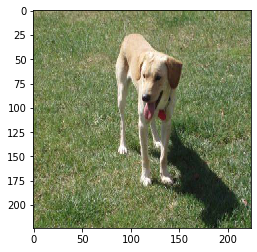

In [6]:
from keras.preprocessing import image
from matplotlib.pyplot import imshow

fnames = [os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)]
img_path = fnames[1] # Choose one image to view
img = image.load_img(img_path, target_size=(224, 224)) # load image and resize it
x = image.img_to_array(img) # Convert to a Numpy array with shape (224, 224, 3)

x = x.reshape((1,) + x.shape)

plt.imshow(image.array_to_img(x[0]))

In [7]:
#from keras.applications.imagenet_utils import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions


model = VGG16(weights='imagenet',include_top=True)

features = model.predict(x)
decode_predictions(features, top=3)

[[('n02109047', 'Great_Dane', 0.41719007),
  ('n02092339', 'Weimaraner', 0.32015273),
  ('n02100236', 'German_short-haired_pointer', 0.13438368)]]

## VGG16 Architecture

In [8]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Nothing too complicated you could build this model yourself like this https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py

More important are the pretrained Imagenet weights, you would otherwise need to download the pictures in ImageNet and train the model on it.

## Build a model

In [9]:
from keras import layers, models, optimizers


conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# The list of classes will be automatically inferred from the subdirectory names/structure under train_dir
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # resize all images to 224 x 224
    batch_size=50,
    class_mode='binary') # because we use binary_crossentropy loss we need binary labels

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224), # resize all images to 224 x 224
    batch_size=50,
    class_mode='binary')

Found 16000 images belonging to 2 classes.
Found 4500 images belonging to 2 classes.


In [12]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=320, # batches in the generator are 50, so it takes 320 batches to get to 16000 images
    epochs=30,
    validation_data=validation_generator,
    validation_steps=90) # batches in the generator are 50, so it takes 90 batches to get to 4500 images

Epoch 1/30
320/320 [==============================] - 64s 201ms/step - loss: 0.6978 - acc: 0.9275 - val_loss: 0.2251 - val_acc: 0.9733
Epoch 2/30
320/320 [==============================] - 63s 197ms/step - loss: 0.3152 - acc: 0.9676 - val_loss: 0.2052 - val_acc: 0.9767
Epoch 3/30
320/320 [==============================] - 64s 201ms/step - loss: 0.2133 - acc: 0.9771 - val_loss: 0.1951 - val_acc: 0.9787
Epoch 4/30
320/320 [==============================] - 64s 200ms/step - loss: 0.1604 - acc: 0.9823 - val_loss: 0.1912 - val_acc: 0.9802
Epoch 5/30
320/320 [==============================] - 65s 202ms/step - loss: 0.1399 - acc: 0.9843 - val_loss: 0.2008 - val_acc: 0.9804
Epoch 6/30
320/320 [==============================] - 64s 200ms/step - loss: 0.1352 - acc: 0.9854 - val_loss: 0.2037 - val_acc: 0.9802
Epoch 7/30
320/320 [==============================] - 64s 201ms/step - loss: 0.1125 - acc: 0.9874 - val_loss: 0.2085 - val_acc: 0.9798
Epoch 8/30
320/320 [==============================] - 6

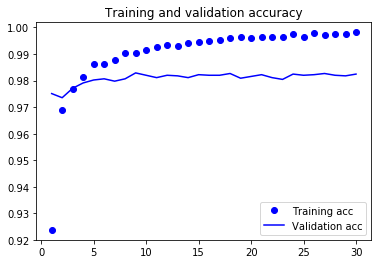

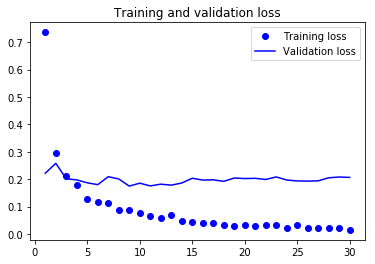

In [14]:
plot_accuracy_and_loss(history)

In [15]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=90)
print('test acc:', test_acc)

Found 4500 images belonging to 2 classes.
test acc: 0.9833333353201549


## Transfer learning / Fine tune model

In [16]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# The list of classes will be automatically inferred from the subdirectory names/structure under train_dir
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # resize all images to 150 x 150
    batch_size=50,
    class_mode='binary') # because we use binary_crossentropy loss we need binary labels

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224), # resize all images to 150 x 150
    batch_size=50,
    class_mode='binary')

Found 16000 images belonging to 2 classes.
Found 4500 images belonging to 2 classes.


In [17]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [19]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=320, # batches in the generator are 50, so it takes 320 batches to get to 16000 images
    epochs=30,
    validation_data=validation_generator,
    validation_steps=90) # batches in the generator are 50, so it takes 90 batches to get to 4500 images

Epoch 1/30
320/320 [==============================] - 151s 471ms/step - loss: 0.7004 - acc: 0.9150 - val_loss: 0.1462 - val_acc: 0.9720
Epoch 2/30
320/320 [==============================] - 150s 469ms/step - loss: 0.1335 - acc: 0.9716 - val_loss: 0.0935 - val_acc: 0.9784
Epoch 3/30
320/320 [==============================] - 150s 470ms/step - loss: 0.0622 - acc: 0.9851 - val_loss: 0.1020 - val_acc: 0.9820
Epoch 4/30
320/320 [==============================] - 150s 470ms/step - loss: 0.0428 - acc: 0.9895 - val_loss: 0.1056 - val_acc: 0.9833
Epoch 5/30
320/320 [==============================] - 150s 470ms/step - loss: 0.0248 - acc: 0.9944 - val_loss: 0.0993 - val_acc: 0.9829
Epoch 6/30
320/320 [==============================] - 150s 470ms/step - loss: 0.0176 - acc: 0.9959 - val_loss: 0.1168 - val_acc: 0.9811
Epoch 7/30
320/320 [==============================] - 151s 470ms/step - loss: 0.0128 - acc: 0.9969 - val_loss: 0.1163 - val_acc: 0.9804
Epoch 8/30
320/320 [============================

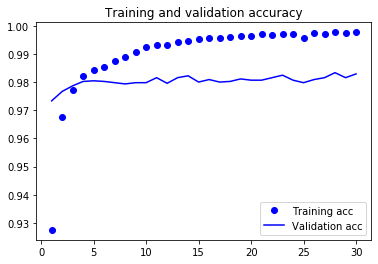

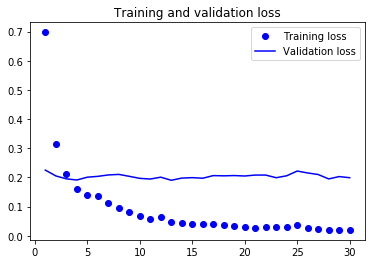

In [13]:
plot_accuracy_and_loss(history)

In [14]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=50,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=90)
print('test acc:', test_acc)

Found 4500 images belonging to 2 classes.
test acc: 0.9844444473584493
